In [1]:
import random
import pandas as pd
import numpy as np
import altair as alt
from collections import Counter

In [11]:
def create_simulated_reward_data(model_accuracies, no_of_rewards):
    """
    Generates a DataFrame of synthetic reward data. Columns are each of the models in the MAB setup. 
    Rows are the reward passed to each model for a given observation. 
    
    Parameters:
        model_accuracies (list): List of each of the model accuracies being compared.
        no_of_rewards (int): Number of rewards observed within the given time window.
    
    Returns: 
        
    """
    rng = np.random.default_rng()
    data = {}
    
    for i in range(len(model_accuracies)):
        data[f"Model {i}"] = rng.binomial(1, model_accuracies[i], no_of_rewards)

    data = pd.DataFrame(data)
    return data

            
def generate_ts_time_series(model_accuracies, time_series_length, no_of_rewards):
    reward_dict = {"rewards": None, "penalties": None}
    results_list = []

    init_rewards = [0] * len(model_accuracies)
    init_penalties = [0] * len(model_accuracies)

    for i in range(time_series_length):

        if i == 0:
            data = create_simulated_reward_data(model_accuracies, no_of_rewards)
            results, rewards, penalties = thompson_sampling_experiment(data, model_accuracies, init_rewards, init_penalties)

            results_list.append(results)
            reward_dict["rewards"] = rewards
            reward_dict["penalties"] = penalties

        else:
            prev_rewards = reward_dict["rewards"]
            prev_penalties = reward_dict["penalties"]

            data = create_simulated_reward_data(model_accuracies, no_of_rewards)
            results, rewards, penalties = thompson_sampling_experiment(data, model_accuracies, prev_rewards, prev_penalties)
            
            results_list.append(results)
            reward_dict["rewards"] = rewards
            reward_dict["penalties"] = penalties

    return results_list

            
def thompson_sampling_experiment(data, model_accuracies, rewards, penalties):
    """
    Returns the number of incorrect classifications made if observations
    were routed using the Thompson Sampling algorithm.
    
    Parameters:
        data (pd.DataFrame): DataFrame where columns are the models, and each row was 
                             the reward passed to the model for a given observation.
        model_accuracies (list): List of each of the model accuracies being compared.
                             
    
    Returns: 
        count_of_model_selected (dict): Dictionary where the keys are the model number and the values
        are the number of times that model was selected for prediction. 
    """
    
    no_of_observations = int(len(data))
    no_of_models = int(len(data.columns))
    
    assert no_of_models == int(len(model_accuracies)), \
            f"The number of models ({no_of_models}) does not match the number of accuracy values ({int(len(model_accuracies))}) provided."
    model_selected = []
    
    for n in range(0, no_of_observations):
        bandit = 0
        beta_max = 0

        for i in range(0, no_of_models):
            beta_d = random.betavariate(rewards[i] + 1, penalties[i] + 1)
            if beta_d > beta_max:
                beta_max = beta_d
                bandit = i

        model_selected.append(bandit)       
        reward = data.values[n, bandit]

        if reward == 1:
            rewards[bandit] = rewards[bandit] + 1
        else:
            penalties[bandit] = penalties[bandit] + 1
    
    count_of_model_selected = dict(Counter(model_selected))
    return count_of_model_selected, rewards, penalties


def generate_control_time_series(model_accuracies, time_series_length, no_of_rewards):
    results_list = []
    
    for i in range(time_series_length):
        data = create_simulated_reward_data(model_accuracies, no_of_rewards)
        results = control_experiment(data, model_accuracies)
        results_list.append(results)
        
    return results_list
    

def control_experiment(data, model_accuracies):
    """
    Returns the model selections made if observations
    were simply split evenly across the models.
    
    Parameters:
        model_accuracies (list): List of each of the model accuracies being compared.
        no_of_observations (int): Number of observations within time window.
        
    Returns: 
        incorrect_preds (list): Number of incorrect observations from each of the
                                models being compared. 
    """
    percentage_split = 1 / len(model_accuracies)
    count_of_model_selected = {}
    
    for i in range(len(model_accuracies)): 
        count_of_model_selected[i] = int(np.floor(len(data) * percentage_split))
    
    diff = len(data) - sum(count_of_model_selected.values())
    if  diff != 0:
        for i in range(diff):
            count_of_model_selected[i] += 1
    
    return count_of_model_selected

In [25]:
# User defined parameters to populate the model. 
MODEL_ACCURACIES = [0.7, 0.955, 0.98, 0.89]
COST_OF_FAILURE = 10
NO_OF_REWARDS = 100
NO_OF_REQUESTS = 1111
TIME_UNIT = "week"
TIME_SERIES_LENGTH = 52

In [26]:
# Generating Thompson Sampling experiment data
ts_bandit_selected = generate_ts_time_series(MODEL_ACCURACIES, TIME_SERIES_LENGTH, NO_OF_REWARDS)

ts_bandit_selected = pd.DataFrame(ts_bandit_selected)
ts_bandit_selected.fillna(0, inplace=True)
ts_bandit_selected = ts_bandit_selected.astype(int)
ts_bandit_selected.loc['Totals'] = ts_bandit_selected.sum(numeric_only=True, axis=0)
print(ts_bandit_selected)

        0     2    1   3
0       2    53   34  11
1       0    92    8   0
2       0    99    1   0
3       1    93    6   0
4       1    81   14   4
5       0    74   25   1
6       0    79   18   3
7       0    70   30   0
8       0    68   32   0
9       0    81   19   0
10      0    83   17   0
11      0    96    4   0
12      0    93    7   0
13      0    99    1   0
14      0    98    2   0
15      0    99    1   0
16      0    99    1   0
17      0   100    0   0
18      0    98    2   0
19      0    98    2   0
20      0    99    0   1
21      0   100    0   0
22      0   100    0   0
23      0   100    0   0
24      0   100    0   0
25      0   100    0   0
26      0    99    1   0
27      0    98    2   0
28      0   100    0   0
29      0   100    0   0
30      0   100    0   0
31      0    98    2   0
32      0   100    0   0
33      0   100    0   0
34      0    99    1   0
35      0   100    0   0
36      0    99    1   0
37      0   100    0   0
38      0    99    1   0


In [27]:
(NO_OF_REQUESTS // NO_OF_REWARDS)

11

In [20]:
# Generating Thompson Sampling experiment data
ts_bandit_selected = generate_ts_time_series(MODEL_ACCURACIES, TIME_SERIES_LENGTH, NO_OF_REWARDS)

ts_bandit_selected = pd.DataFrame(ts_bandit_selected)
ts_bandit_selected.fillna(0, inplace=True)
ts_bandit_selected = ts_bandit_selected.astype(int)
ts_bandit_selected.loc['Totals'] = ts_bandit_selected.sum(numeric_only=True, axis=0)
ts_bandit_select = ts_bandit_selected * (NO_OF_REQUESTS // NO_OF_REWARDS)

ts_misclassifications_dict = {}
for i in ts_bandit_selected.columns:
    ts_misclassifications_dict[i] = (ts_bandit_selected[i] * (1 - MODEL_ACCURACIES[i])).round().astype(int)

ts_misclassifications = pd.DataFrame(ts_misclassifications_dict)

# Generating control experiment data
control_bandit_selected = generate_control_time_series(MODEL_ACCURACIES, TIME_SERIES_LENGTH, NO_OF_REWARDS)

control_bandit_selected = pd.DataFrame(control_bandit_selected)
control_bandit_selected.fillna(0, inplace=True)
control_bandit_selected = control_bandit_selected.astype(int)
control_bandit_selected.loc['Totals'] = control_bandit_selected.sum(numeric_only=True, axis=0)
control_bandit_selected = control_bandit_selected * (NO_OF_REQUESTS // NO_OF_REWARDS)

control_misclassifications_dict = {}
for i in control_bandit_selected.columns:
    control_misclassifications_dict[i] = (control_bandit_selected[i] * (1 - MODEL_ACCURACIES[i])).round().astype(int)

control_misclassifications = pd.DataFrame(control_misclassifications_dict)

total_ts_misclassifications = sum(ts_misclassifications.iloc[-1, :])
total_control_misclassifications = sum(control_misclassifications.iloc[-1, :])
misclassification_diff = total_control_misclassifications - total_ts_misclassifications
cost_incurred = misclassification_diff * COST_OF_FAILURE
cost_incurred

60550

In [5]:
ts_misclassifications

,1,2,0,3
0,3,1,1,0
1,3,1,0,0
2,2,1,0,0
3,2,1,0,0
4,3,1,0,0
5,3,1,0,0
6,3,1,0,0
7,3,1,0,0
8,2,1,0,0
9,1,2,0,0


In [100]:
ts_misclassifications.sum(axis=1).iloc[:-1].cumsum()

0       4
1       6
2       8
3      10
4      12
5      14
6      16
7      18
8      20
9      22
10     24
11     26
12     28
13     30
14     32
15     34
16     36
17     38
18     40
19     42
20     44
21     46
22     48
23     50
24     52
25     54
26     56
27     58
28     60
29     62
30     64
31     66
32     68
33     70
34     72
35     74
36     76
37     78
38     80
39     82
40     84
41     86
42     88
43     90
44     92
45     94
46     96
47     98
48    100
49    102
50    104
51    106
dtype: int64

In [101]:
ts_misclassifications.sum()

3      0
1      5
0      3
2    205
dtype: int64

In [102]:
control_misclassifications.sum()

0    806
1    111
2     78
3    299
dtype: int64

In [48]:
model_misclassifications = pd.concat([control_misclassifications.sum(), ts_misclassifications.sum()], axis=1)
model_misclassifications.index = model_misclassifications.index + 1
model_misclassifications.columns = ["Control", "Thompson Sampling"]
model_misclassifications.loc['Totals'] = model_misclassifications.sum(numeric_only=True, axis=0)
# pd.concat([model_misclassifications, model_misclassifications.sum(numeric_only=True, axis=0)])
model_misclassifications

,Control,Thompson Sampling
1,7800,3
2,1157,42
3,520,188
4,2834,2
Totals,12311,235


In [47]:
totals = pd.Series(model_misclassifications.sum(numeric_only=True, axis=0), name="Totals")
model_misclassifications.append(totals)

,Control,Thompson Sampling
1,7800,3
2,1157,42
3,520,188
4,2834,2
Totals,12311,235


In [94]:
alt.Chart(total_cumsum).mark_line().encode(
    x='Time step',
    y='Cost of failure',
    color='Algorithm',
    strokeDash='Algorithm',
).interactive()

alt.Chart(...)

In [93]:
# # Create a selection that chooses the nearest point & selects based on x-value
# nearest = alt.selection(type='single', nearest=True, on='mouseover',
#                         fields=['Time step'], empty='none')

# # The basic line
# line = alt.Chart(total_cumsum).mark_line(interpolate='basis').encode(
#     x='Time step',
#     y='Cost of failure',
#     color='Algorithm',
#     strokeDash='Algorithm',
# ).interactive()

# # Transparent selectors across the chart. This is what tells us
# # the x-value of the cursor
# selectors = alt.Chart(total_cumsum).mark_point().encode(
#     x='Time step',
#     opacity=alt.value(0),
# ).add_selection(
#     nearest
# )

# # Draw points on the line, and highlight based on selection
# points = line.mark_point().encode(
#     opacity=alt.condition(nearest, alt.value(1), alt.value(0))
# )

# # Draw text labels near the points, and highlight based on selection
# text = line.mark_text(align='left', dx=5, dy=-5).encode(
#     text=alt.condition(nearest, 'Cost of failure', alt.value(' '))
# )

# # Draw a rule at the location of the selection
# rules = alt.Chart(total_cumsum).mark_rule(color='gray').encode(
#     x='Time step',
# ).transform_filter(
#     nearest
# )

# # Put the five layers into a chart and bind the data
# alt.layer(
#     line, selectors, points, rules, text
# ).properties(
#     width=600, height=300
# )

alt.LayerChart(...)

In [64]:
ts_cumsum

0                             9
1                            13
2                            17
3                            20
4                            22
5                            24
6                            26
7                            28
8                            30
9                            32
10                           34
11                           36
12                           38
13                           40
14                           42
15                           44
16                           46
17                           48
18                           50
19                           52
20                           54
21                           56
22                           58
23                           60
24                           62
25                           64
26                           66
27                           68
28                           70
29                           72
30                           74
31      

In [55]:
misclassifications_df = pd.concat([ts_misclassifications.sum(axis=1).iloc[:-1].cumsum(), control_misclassifications.sum(axis=1).iloc[:-1]],
          axis=0)
misclassifications_df.columns = ["Thompson Sampling", "Control"]
misclassifications_df

,Thompson Sampling,Control
0,9,13
1,4,13
2,4,13
3,3,13
4,2,13
5,2,13
6,2,13
7,2,13
8,2,13
9,2,13


In [59]:
fig = (
    alt.Chart(misclassification_df.reset_index(), title="MAB vs Control")
    .mark_line()
    .encode(x="index:T", y="bill_length_mm:Q")
    .interactive()
)

alt.Chart(...)

In [61]:
from vega_datasets import data
source = data.stocks()
source

,symbol,date,price
0,MSFT,2000-01-01,39.81
1,MSFT,2000-02-01,36.35
2,MSFT,2000-03-01,43.22
3,MSFT,2000-04-01,28.37
4,MSFT,2000-05-01,25.45
...,...,...,...
555,AAPL,2009-11-01,199.91
556,AAPL,2009-12-01,210.73
557,AAPL,2010-01-01,192.06
558,AAPL,2010-02-01,204.62


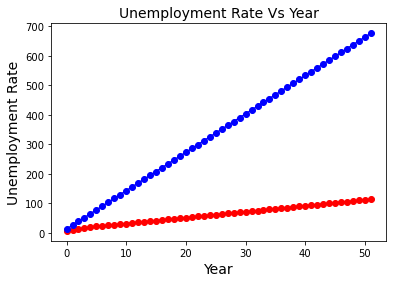

In [48]:
plt.plot(ts_misclassifications.sum(axis=1).iloc[:-1].cumsum(), color='red', marker='o')
plt.plot(control_misclassifications.sum(axis=1).iloc[:-1].cumsum(), color='blue', marker='o')

plt.title('Unemployment Rate Vs Year', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Unemployment Rate', fontsize=14)
plt.show()